# Benchmarking CLgen
-----
Dec 2016.

In [1]:
# preamble
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from labm8 import fs
from labm8 import viz

import clgen
from clgen import corpus

## Experimental methodology

Experimental platforms: cc[123]. NVIDIA GTX 1080.

* Train on GitHub corpus.
* Generate 1000 samples.
* Reject bad samples.

Commands:

```
$ export CUDA_VISIBLE_DEVICES=0
$ export MODEL=model-128x3x50
$ cd ~/phd/lab/clgen/benchmark
$ python ./benchmark.py $MODEL.json 2>&1 | tee benchmark-$MODEL.log
$ clgen-dist $MODEL.json ~/data/dist/$MODEL -v
```

In [2]:
c = corpus.Corpus.from_json({"path": "~/data/github"})
print("CLgen:      ", clgen.version())
print("Corpus size:", c.size)
print("Vocab size: ", c.vocab_size)

CLgen:       0.2.1
Corpus size: 20271852
Vocab size:  92


## Experimental results

In [3]:
def parse_file(path):
    """ return model size, num layers, and epochs """
    import re
    m = re.search(r"([0-9]+)x([0-9]+)x([0-9]+)", path)
    return m.group(1), m.group(2), m.group(3) 

data_files = ["benchmark/" + x for x in fs.ls("benchmark")
              if x.startswith("benchmark-") and x.endswith(".json")]
data = dict((parse_file(x), clgen.load_json_file(x)) for x in data_files)
print("read {} data files".format(len(data)))

read 8 data files


## Evaluation

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
plt.style.use(["seaborn-white", "seaborn-paper"])

def label(path):
    return '-'.join([str(x) for x in path])

# sort key values
sorted_keys = sorted(data.keys(), key=lambda x: [int(y) for y in x])

### Training Rate

$Time\ per.\ epoch = \frac{training\_time}{num\_epochs}$

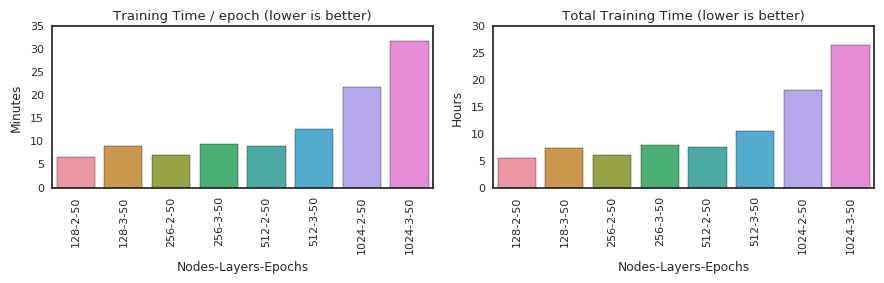

In [5]:
ax = plt.subplot(1, 2, 1)
x, y = zip(*[(label(x), data[x]["training_time"] / float(x[2]) / 60)
             for x in sorted_keys])
sns.barplot(x, y)
plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
plt.title("Training Time / epoch (lower is better)")
plt.xlabel("Nodes-Layers-Epochs")
plt.ylabel("Minutes")

ax = plt.subplot(1, 2, 2)
x, y = zip(*[(label(x), data[x]["training_time"] / 3600)
             for x in sorted_keys])
sns.barplot(x, y)
plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
plt.title("Total Training Time (lower is better)")
plt.xlabel("Nodes-Layers-Epochs")
plt.ylabel("Hours")

viz.finalise(figsize=(9, 3))

### Sampling Rate

$Time\ per.\ sample = \frac{sampling\_time}{num\_samples}$

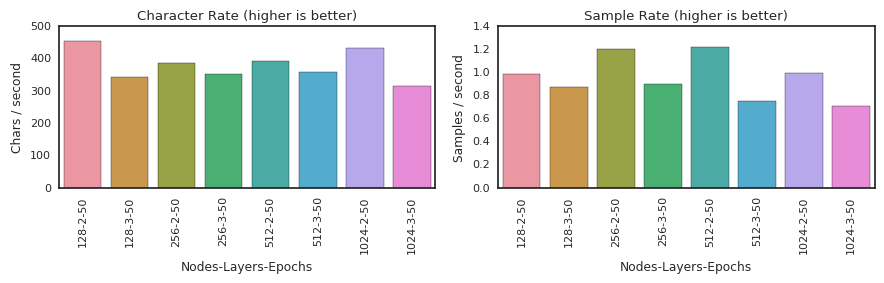

In [6]:
ax = plt.subplot(1, 2, 1)
x, y = zip(*[(label(x), data[x]["total_charcount"] / data[x]["sampling_time"])
             for x in sorted_keys])
sns.barplot(x, y)
plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
plt.title("Character Rate (higher is better)")
plt.xlabel("Nodes-Layers-Epochs")
plt.ylabel("Chars / second")

ax = plt.subplot(1, 2, 2)
x, y = zip(*[(label(x), data[x]["num_kernels"] / data[x]["sampling_time"])
             for x in sorted_keys])
sns.barplot(x, y)
plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
plt.title("Sample Rate (higher is better)")
plt.xlabel("Nodes-Layers-Epochs")
plt.ylabel("Samples / second")

viz.finalise(figsize=(9, 3))

### Sampling Throughput

$Char\ Throughput = \frac{num\_good\_chars}{sample\_time}$

$Sample\ Throughput = \frac{num\_good\_samples}{sample\_time}$

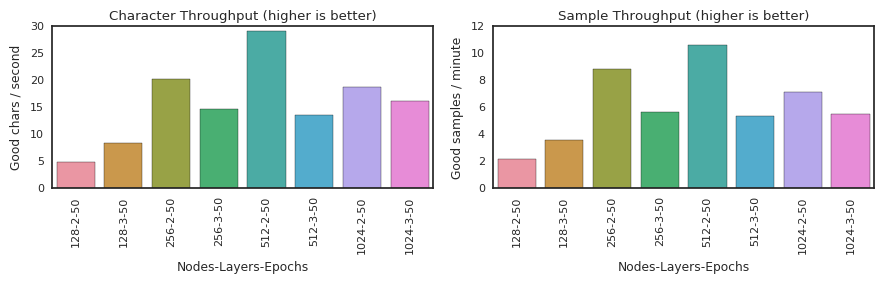

In [7]:
ax = plt.subplot(1, 2, 1)
x, y = zip(*[(label(x), data[x]["good_charcount"] / data[x]["sampling_time"])
             for x in sorted_keys])
sns.barplot(x, y)
plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
plt.title("Character Throughput (higher is better)")
plt.xlabel("Nodes-Layers-Epochs")
plt.ylabel("Good chars / second")

ax = plt.subplot(1, 2, 2)
x, y = zip(*[(label(x), data[x]["num_good_kernels"] / data[x]["sampling_time"] * 60)
             for x in sorted_keys])
sns.barplot(x, y)
plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
plt.title("Sample Throughput (higher is better)")
plt.xlabel("Nodes-Layers-Epochs")
plt.ylabel("Good samples / minute")

viz.finalise(figsize=(9, 3))

### Sampling Efficiency

$Char\ Efficiency = \frac{num\_good\_chars}{num\_chars}$

$Sample\ Efficiency = \frac{num\_good\_samples}{num\_samples}$

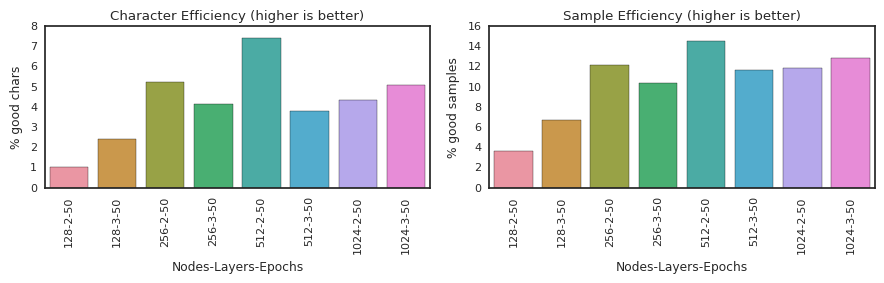

In [8]:
ax = plt.subplot(1, 2, 1)
x, y = zip(*[(label(x), data[x]["efficiency"] * 100)
             for x in sorted_keys])
sns.barplot(x, y)
plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
plt.title("Character Efficiency (higher is better)")
plt.xlabel("Nodes-Layers-Epochs")
plt.ylabel("% good chars")

ax = plt.subplot(1, 2, 2)
x, y = zip(*[(label(x), (data[x]["num_good_kernels"] / data[x]["num_kernels"]) * 100)
             for x in sorted_keys])
sns.barplot(x, y)
plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
plt.title("Sample Efficiency (higher is better)")
plt.xlabel("Nodes-Layers-Epochs")
plt.ylabel("% good samples")

viz.finalise(figsize=(9, 3))